# snnTorch - Classifying Audio with a Convolutional Spiking Neural Network
### By Akash Pandit


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
In this tutorial, we'll be covering the following:
- Learning how to parse audio data and train a network with it
- Building a custom PyTorch dataset
- Methods for transforming audio data
- Constructing a CSNN with the `nn.Sequential` container
- Training and evaluating results

At the end, hopefully you will have a better understanding of methods of working with audio data and convolutional spiking neural networks with PyTorch and snnTorch.

You will need to have downloaded these libraries prior to running this tutorial:
- snntorch
- torch
- torchaudio
- pandas
- matplotlib
- librosa
- (windows users) soundfile
- (linux/mac users) sox

In [40]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as snnfunc
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torchaudio import load
from torchaudio import transforms as audioTFs
from torch.utils.data import Dataset, DataLoader, random_split

from pandas import read_csv
import matplotlib.pyplot as plt
from librosa import power_to_db
from time import perf_counter

In [41]:
# set our device for tensor computation
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# 1. Getting Our Data

Our dataset for this tutorial has two traits that make it unique to that of the other snnTorch tutorials: 1. It's an external dataset that doesn't come prebuilt with pytorch and 2. It's an audio dataset. Right now, we need to tackle that its not a torch-included dataset.

Our dataset can be found and downloaded off of kaggle [here](https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist). The kaggle publisher isn't the original author, but the source can be found at [this GitHub link](https://github.com/soerenab/AudioMNIST). Their paper on this topic will be cited below:

> <cite> [Sören Becker, Johanna Vielhaben, Marcel Ackermann, Klaus-Robert Müller, Sebastian Lapuschkin, and Wojciech Samek "AudioMNIST: Exploring Explainable Artificial Intelligence for Audio Analysis on a Simple Benchmark". Computing Research Repository, abs/1807.03418, 2018.](https://arxiv.org/abs/1807.03418) </cite>

#### Manual Download
You can download the dataset from the kaggle url in the markdown cell above and move it to this notebook's directory to be used. You'll get a folder called `archive.zip`, simply unzip that folder and you have your data.

#### Command Line
You can also download the dataset with the kaggle command like api. If you haven't set up kaggle's CLI api on this machine, [follow this guide](https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/) for any linux-based command line. It'll unzip into a file called `audio-mnist.zip`, and you can unzip it with a quick `$ unzip audio-mnist.zip`.

```kaggle datasets download sripaadsrinivasan/audio-mnist```

nce we download our dataset, we're going to need to make a custom dataset wrapper class with `__len__` and `__getitem__` magic methods, allowing you to take the length of and index the dataset respectively. One approach to making this dataset is written 2 cells below. For this approach, an annotations file will also be needed, the below cell will quickly generate one in our data folder from the dataset.

In [42]:
speaker_count = 60
digit_count = 10
digit_iters = 50
lines = ['filename,speaker,iteration,classification\n']

for speaker in range(speaker_count):
    speaker = str(speaker+1) if speaker > 8 else '0'+str(speaker+1)
    for digit in range(digit_count):
        for iteration in range(digit_iters):
            filename = f'{digit}_{speaker}_{iteration}.wav'
            lines.append(f'{filename},{speaker},{iteration},{digit}\n')

with open('./data/audioMNIST_annotations.csv', 'w', newline='\n') as file:
    file.writelines(lines)

In [66]:
# define a dataset superclass for this particular dataset
class AudioMNISTDataset(Dataset):
    def __init__(self, annotations_file, audio_dir) -> None:
        self.annotations = read_csv(annotations_file)
        self.audio_dir = audio_dir
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_file_path = self.getAudioPath(index=index)
        label = self.annotations.loc[index, 'classification']
        waveform, _ = load(audio_file_path)

        return waveform, label
    
    def getAudioPath(self, index):
        audio_file_name = self.annotations.loc[index, 'filename']
        speaker = str(self.annotations.loc[index, 'speaker'])
        if len(speaker) != 2:
            speaker = '0' + speaker

        audio_file_path = f'{self.audio_dir}/{speaker}/{audio_file_name}'
        return audio_file_path
    

# initialize dataset parameters
annotations_file_path = './data/audioMNIST_annotations.csv'
audio_dir_path = './data'

# initialize dataset
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

There's a small problem though: our audio files are of differing lengths, most are nearly 1 second long (48000 samples at a 48000/s sample rate) but none are over the length (see below cell). 

We want to make sure each sample is of equal length to avoid the model spontaneously combusting because data entries aren't uniform in length. To do this without removing any existing features is to pad every file with some zeros.

What's the padding threshold? We're arbitrarily picking 48000 samples as given our 48000 sampling rate, that makes a file of exactly 1 second long while only being 2 samples longer than the largest sample size (see below cell). It will also help with clean dimensions to work with for model construction down the line.

In [44]:
# # verify the range of lengths for our audio files
min = torch.inf
max = 0
for i in range(30000):
    tLen = len(audio_dataset[i][0][0])
    if tLen < min:
        min = tLen
    if tLen > max:
        max = tLen
    print(i, '/ 30000 samples checked', end='\r')

print('min:', min, 'max:', max)

min: 14073 max: 47998 checked


Feel free to comment out the above cell if you plan on hitting 'Run All' later through the notebook, that cell takes a while to execute and only exists for EDA (exploratory data analysis) purposes, not for any actual functionality.

### 1.1 Installing a Sound Backend

If you haven't worked with audio files before on your system, you're going to want to install a sound backend package. 

For windows users, install soundfile with `pip install soundfile`.

For linux based users (Linux, Ubuntu, Mac OS), install the sox package with `pip install sox`. 

# 2. Transforming Our Data
So we want to pad each audio to 48000 samples, how do we do that to the dataset?

If we look up to the cell defining AudioMNISTDataset, we'll see some commented out lines. Since this dataset class generates the tensors dynamically as indexed, the transformation would also occur dynamically. To change this dataset, let's redefine the indexing magic method (`__getitem__`) to a redesigned version including the first transformation.

In [67]:
def padAudio(waveform: torch.TensorType):
    """Pad a column waveform (torch.Tensor([[x1, x2, ... xn]])) with 0s
    up to a duration of 1 second (48000 samples)"""
    wf = waveform.flatten()
    return torch.cat((wf, torch.zeros(48000-len(wf)))).unsqueeze(dim=0)

def getPaddedAudio(self, index):
    audio_file_path = self.getAudioPath(index=index)
    label = str(self.annotations.loc[index, 'classification'])
    waveform, _ = load(audio_file_path)

    # apply transforms
    waveform = padAudio(waveform)

    return waveform, label

# get audio vector length with old __getitem__ method
print('First Audio Vector Length:', len(audio_dataset[0][0][0]))

AudioMNISTDataset.__getitem__ = getPaddedAudio
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# get audio vector length with new __getitem__ method
print('First Audio Vector Length (Post-padding):', len(audio_dataset[0][0][0]))

First Audio Vector Length: 35877
First Audio Vector Length (Post-padding): 48000


Let's get an idea of how the audio actually looks graphed out:

In the below cell, we have a function that can plot our waves onto a graph. Feel free to mess with the `minIter`, `maxIter`, and `step` variables to view different waveform graphs. A guide is written in the comments above where you can see how many iterations it will take for a new digit or speaker.

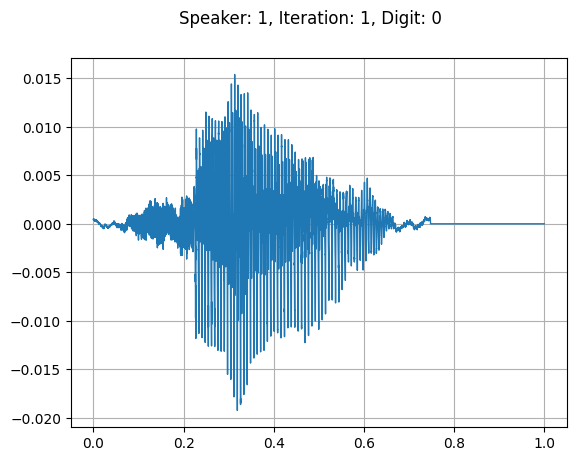

In [46]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


# every 50 files: new digit, iterations reset
# every 500 files: new speaker, digits & iterations reset
# total speakers: 60, total files: 30000
minIter = 0
maxIter = 500
step = 500
for i in range(minIter, maxIter, step):
    plot_waveform(audio_dataset[i][0], 48000, title=f'Speaker: 1, Iteration: 1, Digit: {i//50}')

That's one example of what we can expect each digit's waveform to look. However, one of the most useful features in sound classification is its mel-spectrogram. Mel-spectrograms are often used in deep learning applications in audio transformation, and is the method I'll be using in this notebook. 

Spectrograms are a way to visualize audio data in 3 dimensions: the x coordinate is your time scale, the y coordinate is your frequency (or frequency bin) and your z coordinate (or the color of a point) represents the strength of the presence of a frequency at time x.

Since the way hertz are interpreted is nonlinear (as humans perceive lower frequencies better than higher frequencies), the mel transform was devised to make it so that an increase of m Hz would make the sound to be perceived as n times louder, no matter if the difference is between 100 and 100+n Hz or 1000 and 1000+n Hz. 

In [47]:
# define a spectrogram transform
mel_spectrogram = audioTFs.MelSpectrogram(
    sample_rate=48000,
    n_mels=64,
    n_fft=1024
)

Let's plot some of our spectrograms. The function below allows us to plot data passed to our transform defined above. Feel free to toy with minIter, maxIter, and step to plot whichever files you wish. For example, to plot the first iteration each speaker says the digit 0, minIter remains at 0, maxIter goes to 30000, and step gets set to 500.

If you plot a large amount of graphs and scroll through them really quickly, you can see how each digit's spectrograms roughly resemble each other and how they differentiate from other digits, despite factors such as the accents of each speaker.

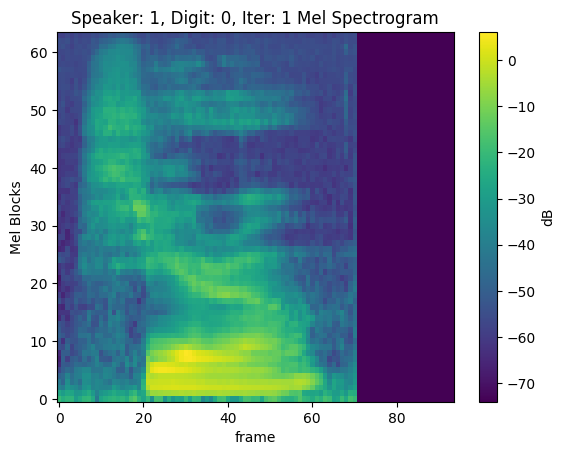

In [48]:
def plot_spectrogram(spectrogram, filenum):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(f'Speaker: {filenum//500+1}, Digit: {(filenum//50)%10}, Iter: {filenum%50+1} Mel Spectrogram')
    axs.set_ylabel('Mel Blocks')
    axs.set_xlabel('frame')
    im = axs.imshow(power_to_db(spectrogram), origin='lower', aspect='auto')
    fig.colorbar(im, ax=axs).set_label('dB')
    plt.show(block=False)

# every 50 files: new digit, iterations reset
# every 500 files: new speaker, digits & iterations reset
# total speakers: 60, total files: 30000
minIter = 0
maxIter = 50
step = 50

for i in range(minIter, maxIter, step):
    aud_tensor = audio_dataset[i][0][0]
    spec = mel_spectrogram(aud_tensor)
    plot_spectrogram(spectrogram=spec, filenum=i)

Let's just confirm all our spectrogram tensors are the same size so our model doesn't have a stroke...

In [49]:
size = mel_spectrogram(audio_dataset[0][0][0]).size()
print(size)

for i in range(30000):
    assert mel_spectrogram(audio_dataset[i][0][0]).size() == size

torch.Size([64, 94])


As machine learning models tend to work best when data is normalized in the [0, 1] range, we're going to also provide a normalization transform at the same time. Just as when padding the audio tensors with 0s was introduced, we will take the `getNormalizedSpec()` function and re-define our class' `__getitem__()` indexing method.

In [78]:
def Normalize01Tensor(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def getNormalizedSpec(self, index):
    # grab raw audio waveform tensor
    audio_file_path = self.getAudioPath(index=index)
    label = self.annotations.loc[index, 'classification']
    waveform, _ = load(audio_file_path)

    # pad 0s
    waveform = padAudio(waveform)
    # spectrogram transformation
    spec_tensor = mel_spectrogram(waveform[0])  # remembering that our mel spectrogram transform worked with flattened data, [[data]][0] == [data]
    spec_tensor = torch.Tensor(power_to_db(spec_tensor)).unsqueeze(dim=0)

    # normalization
    return Normalize01Tensor(spec_tensor), label


# copied from padded audio cell to allow reusability without having to run that cell again
AudioMNISTDataset.__getitem__ = getPaddedAudio
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# apply transform to dataset
AudioMNISTDataset.__getitem__ = getNormalizedSpec
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

Now that we've finished applying our three transforms, we can build our train and test splits for our dataset and dataloaders. The split will ensure that the model will not be tested on any data that will be used for training, preventing it from learning its testing data prior to evaluation. The dataloaders will package our data neatly into batches whose contents can be used by our model to train itself in parallel.

In [79]:
"""
Split the finally transformed data into train and test sets and wrap them in dataloaders
"""
train_data, test_data = random_split(dataset=audio_dataset, lengths=(24000, 6000))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, drop_last=True)

"""Confirm the size of our batches"""
train_batch, _ = next(iter(train_loader))
train_batch.size()  # output format: torch.Size([batches, channels, height, width])

torch.Size([128, 1, 64, 94])

# 3. Defining Our Model
I'll be using an architecture inspired by [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_6.html) on the snnTorch docs:

12C5-MP3-32C5-MP2-32C5-1152FC10

- `M`C`N` is a `N`x`N` convolutional kernel with `M` output channels
- MP`N` is a `N`x`N` max pooling function
- `M`FC`N` is a fully-connected layer that maps `M` neurons to `N` outputs. 

Convolutional kernels and fully connected layers must receive inputs of width `M` so the underlying matrix multiplication can run.

I've tweaked with the `beta` and spike grad `slope` hyperparameters and landed on 0.55 and 15 respectively as solid values for training this model.

In [90]:
# set model hyperparameters
beta = 0.55
spike_grad = surrogate.fast_sigmoid(slope=15)
num_steps = 50

# dims (h*w) of 1 input tensor in batch
# input: 64*94
# post 1st conv2d: 60*90
# post 1st maxpool2d: 20*30
# post 2nd conv2d: 16*26
# post 2nd maxpool2d: 8*13
# post 3rd conv2d: 4*9

model = nn.Sequential(
    nn.Conv2d(1, 12, 5),
    nn.MaxPool2d(3),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(32, 32, 5),
    nn.Flatten(),
    nn.Linear(32*4*9, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device=device)

Since we're using a `nn.Sequential` container for our model instead of wrapping it in a class, we need to define our own forward pass function. In every forward pass, output spikes are collected from the model and recorded for each number of steps passed to the function. Running the below cell once won't train our model entirely, it'll only pass through one given batch of data. However, this `forward_pass` function will be essential for our training loop. 

In [82]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)

    return torch.stack(spk_rec), torch.stack(mem_rec)

# take a forward pass
data, targets = next(iter(train_loader))
data = data.to(device)
targets = torch.Tensor([int(num) for num in targets]).type(torch.long).to(device)
spk_rec, mem_rec = forward_pass(net=model, num_steps=100, data=data)

Beyond moving forward, we'll need to define our loss function. This will be essential for determining just how far off our predictions are from their mark, and those distances will be what's used to train our learnable weights for better predictions.

In [83]:
"""
Define loss functions and values and accuracy
"""

loss_fn = snnfunc.ce_rate_loss()
loss_val = loss_fn(spk_rec, targets)
print(f"The loss from an untrained network is {loss_val.item():.3f}")
acc = snnfunc.accuracy_rate(spk_rec, targets)
print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The loss from an untrained network is 2.303
The accuracy of a single batch using an untrained network is 7.812%


To calculate the accuracy of our model, we'll be using a modified version of the `batch_accuracy` function from [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_6.html). As we're passing data to our model in batches, we have an accuracy function that can evaluate our average batch accuracy rather than the accuracy of each individual data point.

In [84]:
"""
Defining a function that finds the accuracy across an entire batch of data
"""

def batch_accuracy(train_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        train_loader = iter(train_loader)
        for data, targets in train_loader:
            data = data.to(device)
            targets = torch.Tensor([int(label) for label in targets])
            targets = targets.to(device).type(torch.long)
            spk_rec, _ = forward_pass(net, num_steps, data)

            acc += snnfunc.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total

# 4. Training the model
Now that we have a model, let's get to training it. Our training method is a modified version of that which appears in [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_6.html), modified to work with this model. Training occurs in a nested loop, with the train loader's data:target pairs being iterated over for however many epochs we decide to train for. This model converges a little slow, so I have 5 epochs put down. 5 epochs will take a while though (with a 12GB NVIDIA RTX 3060 it took ~30 minutes), so feel free to drop that epoch count.

The model will initialize its data and targets and execute a forward pass for 50 steps for that batch. Afterwards, loss is calculated and used to optimize our learnable parameters in a janky, snn-ified backpropogation step. Every 50 steps, the model will pause its training and have its accuracy evaluated, stored, and printed to the console. At the end of each batch, the accuracy will be evaluated and printed again. This process loops until the train loader is fully passed through for every epoch, leaving you with a trained model.

In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 5
loss_hist = []
test_acc_hist = []
counter = 0

start_time = exec_time = perf_counter()

# Outer training loop
print("beta:", beta, "spike grad slope: 15", "learning rate: 0.005", "device:", device, '\n')
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        model.to(device=device).train()
        spk_rec, _ = forward_pass(model, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % num_steps == 0:
            with torch.no_grad():
                model.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, model, num_steps)
                # TODO: test_f1, test_log_loss
                cur_time = perf_counter()
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%, Batch Time: {round(cur_time-exec_time, 3)}s, Total Time: {round(cur_time-start_time, 3)}s, Epoch {epoch}\n")
                exec_time = cur_time
                test_acc_hist.append(test_acc.item())

        counter += 1
    model.eval()
    test_acc = batch_accuracy(test_loader, model, num_steps)
    cur_time = perf_counter()
    print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%, Batch Time: {round(cur_time-exec_time, 3)}s, Total Time: {round(cur_time-start_time, 3)}s, END OF EPOCH {epoch}\n")
    exec_time = cur_time


beta: 0.55 spike grad slope: 15 learning rate: 0.005 device: cuda 

Iteration 0, Test Acc: 9.51%, Batch Time: 12.785s, Total Time: 12.785s, Epoch 0

Iteration 50, Test Acc: 74.93%, Batch Time: 60.24s, Total Time: 73.025s, Epoch 0

Iteration 100, Test Acc: 87.74%, Batch Time: 58.492s, Total Time: 131.517s, Epoch 0

Iteration 150, Test Acc: 93.90%, Batch Time: 66.551s, Total Time: 198.068s, Epoch 0

Iteration 187, Test Acc: 90.73%, Batch Time: 60.735s, Total Time: 258.803s, END OF EPOCH 0

Iteration 200, Test Acc: 90.01%, Batch Time: 37.11s, Total Time: 295.913s, Epoch 1

Iteration 250, Test Acc: 95.06%, Batch Time: 65.329s, Total Time: 361.242s, Epoch 1

Iteration 300, Test Acc: 96.13%, Batch Time: 88.552s, Total Time: 449.794s, Epoch 1

Iteration 350, Test Acc: 95.33%, Batch Time: 99.763s, Total Time: 549.557s, Epoch 1

Iteration 374, Test Acc: 96.54%, Batch Time: 77.095s, Total Time: 626.652s, END OF EPOCH 1

Iteration 400, Test Acc: 95.79%, Batch Time: 74.684s, Total Time: 701.335s, 

# 5. Results

At the end of 5 epochs with 935 iterations, you should have converged around a testing accuracy of 97.5% At the end of our first epoch, we hit around 92.5% testing accuracy. Let's plot that below with the test accuracy history collected in the training loop:

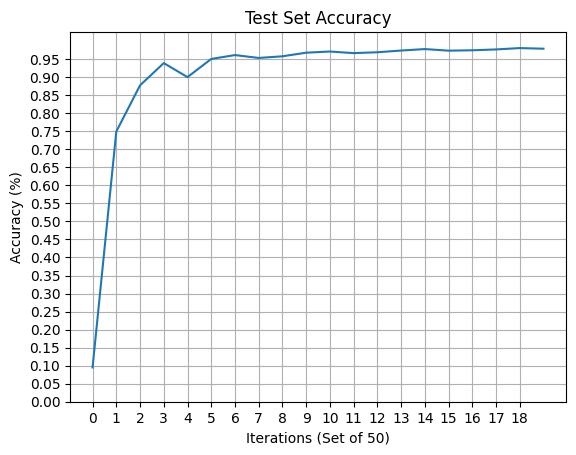

In [108]:
# Plot Loss
test_acc_hist.append(test_acc)
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.grid()
plt.title("Test Set Accuracy")
plt.xticks(range(19))
plt.yticks([i/100 for i in range(0, 100, 5)])
plt.xlabel("Iterations (Set of 50)")
plt.ylabel("Accuracy Score")
plt.show()

# 6. Conclusion

Congratulations! You've just completed this tutorial on building and training a convolutional spiking neural network on audio data. Hopefully, you now know enough to begin building models of your own to start experimenting with audio data- whether it be new model architectures, different ways of loading in data, new datasets, or even just tuning the hyperparameters.

Thank you to Professor Jason Eshraghian for providing this opportunity to build this tutorial.

# 7. Bonus: Comparing With a Classic CNN

Now that we've built and run a convolutional spiking neural network, let's see how it stacks up against a vanilla convolutional neural network.

It'll be running a 12C5-MP3-32C5-MP2-32C5-1152FC10 architecture, identical to the spiking network except without the spiking neurons. 

In [ ]:
cnn_model = nn.Sequential(
    nn.Conv2d(1, 12, 5),
    nn.MaxPool2d(3),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 5),
    nn.Flatten(),
    nn.Linear(64*4*9, 10)
).to(device=device)